# Testing something about PSF on ComCam's ghosts

In [1]:
import batoid
import numpy as np
from ipywidgets import interact
import ipywidgets as widgets
import matplotlib.pyplot as plt
from scipy.signal import fftconvolve

%matplotlib inline

In [2]:
fiducial_telescope = batoid.Optic.fromYaml("ComCamSpiders_r.yaml")

In [3]:
for surface in fiducial_telescope.itemDict.values():
    if isinstance(surface, batoid.RefractiveInterface):
        if surface.name.split('_')[0] in ['L1']:
            surface.forwardCoating = batoid.SimpleCoating(1-0.9519450133010235, 0.9519450133010235)
            surface.reverseCoating = batoid.SimpleCoating(1-0.95194501330102359, 0.9519450133010235)
        elif surface.name.split('_')[0] in ['L2']:
            surface.forwardCoating = batoid.SimpleCoating(1-0.9510109078711367, 0.9510109078711367)
            surface.reverseCoating = batoid.SimpleCoating(1-0.9510109078711367, 0.9510109078711367)
        elif surface.name.split('_')[0] in ['L3']:
            surface.forwardCoating = batoid.SimpleCoating(1-0.9528543599768664, 0.9528543599768664)
            surface.reverseCoating = batoid.SimpleCoating(1-0.9528543599768664, 0.9528543599768664)
        elif surface.name.split('_')[0] in ['Filter']:
            surface.forwardCoating = batoid.SimpleCoating(1-0.9441339435556122, 0.9441339435556122)
            surface.reverseCoating = batoid.SimpleCoating(1-0.9441339435556122, 0.9441339435556122)
        if isinstance(surface, batoid.Detector):
            surface.forwardCoating = batoid.SimpleCoating(1-0.9213684000000424, 0.9213684000000424)

In [4]:
theta_x = np.deg2rad(-0.2213)
theta_y = np.deg2rad(-0.0049)
wavelength = 666e-9

In [5]:
rays = batoid.RayVector.asPolar(
    optic=fiducial_telescope, theta_x=theta_x, theta_y=theta_y, wavelength=wavelength, nrad=300, naz=900, flux=1.0
)
rForward, rReverse = fiducial_telescope.traceSplit(rays, minFlux=1e-3)

In [6]:
x, y, flux = [], [], []
for i, rr in enumerate(rForward):
    x.append([ix for ix in rr.x])
    y.append([iy for iy in rr.y])
    flux.append([iflux for iflux in rr.flux])

In [7]:
nghost = len(x)

if nghost > 0:
    idx_keep = []
    
    fig, axes = plt.subplots(nghost, 1, figsize=(4 * nghost, 4), constrained_layout=True)
    axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]
        
    hexbin_collection = [None] * nghost
    
    for i in range(nghost):
        hexbin_collection[i] = axes[i].hexbin(
            x[i], y[i], extent=[-0.25, 0.25, -0.25, 0.25],
            gridsize=400
        )    
        offsets = hexbin_collection[i].get_offsets()
        counts = hexbin_collection[i].get_array()
            
        hex_size = 0.5 / 400
        hex_area = (3 * np.sqrt(3) / 2) * (hex_size ** 2)
        
        mask = counts > 0
        individual_areas = [hex_area for _ in offsets[mask]]
        flux_update = flux[i][0]/(len(individual_areas)*hex_area)
        print(f"Flux/m2 for ghost {i+1} : {flux_update}")
    
        if flux_update > 1e-1:
            idx_keep.append(i)
        
    plt.close()

Flux/m2 for ghost 1 : 0.03881584674005174
Flux/m2 for ghost 2 : 0.42147717673385693
Flux/m2 for ghost 3 : 0.09602484166365524
Flux/m2 for ghost 4 : 0.05760729867694721
Flux/m2 for ghost 5 : 0.026404685831608786
Flux/m2 for ghost 6 : 0.05955963736915679
Flux/m2 for ghost 7 : 0.019552266060461954
Flux/m2 for ghost 8 : 0.026073564839524763
Flux/m2 for ghost 9 : 0.04145331260753718
Flux/m2 for ghost 10 : 0.03208715631054608
Flux/m2 for ghost 11 : 0.021553667450139195
Flux/m2 for ghost 12 : 0.029481209193640938
Flux/m2 for ghost 13 : 0.05024184829552135
Flux/m2 for ghost 14 : 0.03682987655647481
Flux/m2 for ghost 15 : 7.84559272893206
Flux/m2 for ghost 16 : 0.016474178267089728
Flux/m2 for ghost 17 : 0.038375886737116366
Flux/m2 for ghost 18 : 0.04964905139010809
Flux/m2 for ghost 19 : 0.023371238905194474
Flux/m2 for ghost 20 : 0.019864852340502535
Flux/m2 for ghost 21 : 0.0649540772127466
Flux/m2 for ghost 22 : 0.08607214619040005
Flux/m2 for ghost 23 : 1.9014844985170316
Flux/m2 for ghos

In [8]:
#idx_keep = [14, 23]
xkeep, ykeep, fkeep = [], [], []
for i in idx_keep:
    xkeep.append([ix for ix in x[i]])
    ykeep.append([iy for iy in y[i]])
    fkeep.append([iflux for iflux in flux[i]])

x = np.concatenate([ix for ix in xkeep])
y = np.concatenate([iy for iy in ykeep])
flux = np.concatenate([iflux for iflux in fkeep])

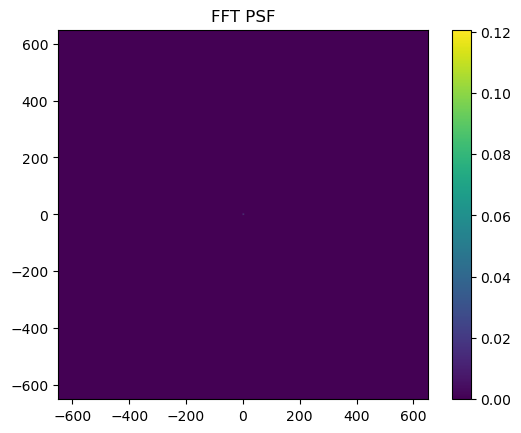

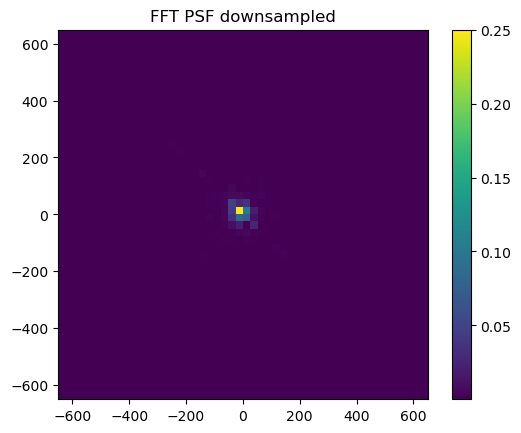

In [9]:
nx=1586
fftpsf = batoid.fftPSF(
    fiducial_telescope, theta_x, theta_y, wavelength, 
    nx=nx, pad_factor=1
)
scale = np.sqrt(np.abs(np.linalg.det(fftpsf.primitiveVectors)))  # meters

extent = scale*fftpsf.array.shape[0]/2*np.r_[-1., 1., -1., 1.] # meters
extent -= scale/2
extent *= 1e6 # microns

plt.imshow(fftpsf.array/fftpsf.array.sum(), extent=extent)
plt.colorbar()
plt.title("FFT PSF")
plt.show()

fftpsf_sub = fftpsf.array[16::32, 16::32]
plt.imshow(fftpsf_sub/fftpsf_sub.sum(), extent=extent)
plt.colorbar()
plt.title("FFT PSF downsampled")
plt.show()

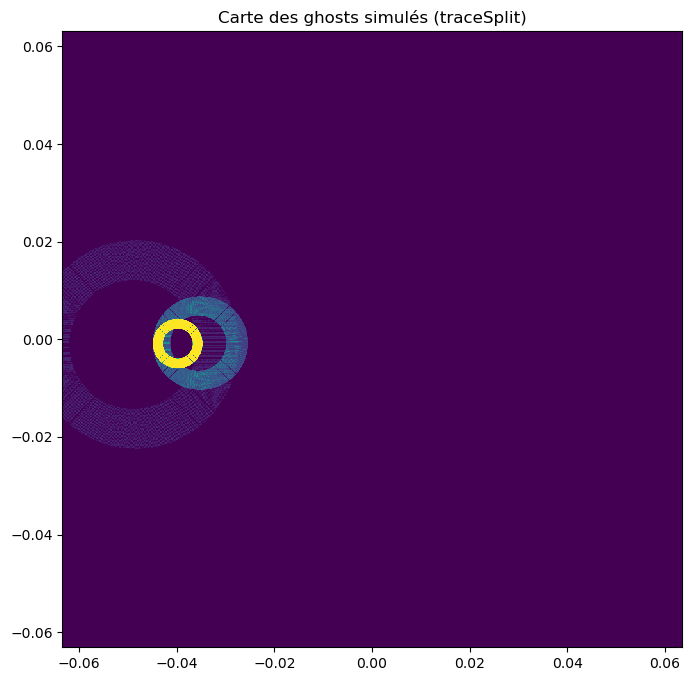

In [10]:
scale = 8.0*1e-5
px = 1586
py = 1577
X, Y = px*scale, py*scale

extent = [-X/2.0, X/2.0, -Y/2.0, Y/2.0]
x_min, x_max, y_min, y_max = extent
    
mask = (x > x_min) & (x < x_max) & (y > y_min) & (y < y_max)
    
x = x[mask]
y = y[mask]
flux = flux[mask]
    
ghost_map, xedges, yedges = np.histogram2d(x, y, bins=[px, py], weights=flux, range=[[x_min, x_max], [y_min, y_max]])

X, Y = np.meshgrid(xedges, yedges)
    
fig, ax = plt.subplots(figsize=(8, 8))
    
im = ax.pcolormesh(X, Y, ghost_map.T, vmax=4e-2)
    
ax.set_aspect("equal")
ax.set_facecolor('black')
#plt.xticks([])
#plt.yticks([])
plt.title("Carte des ghosts simulés (traceSplit)")
plt.show()

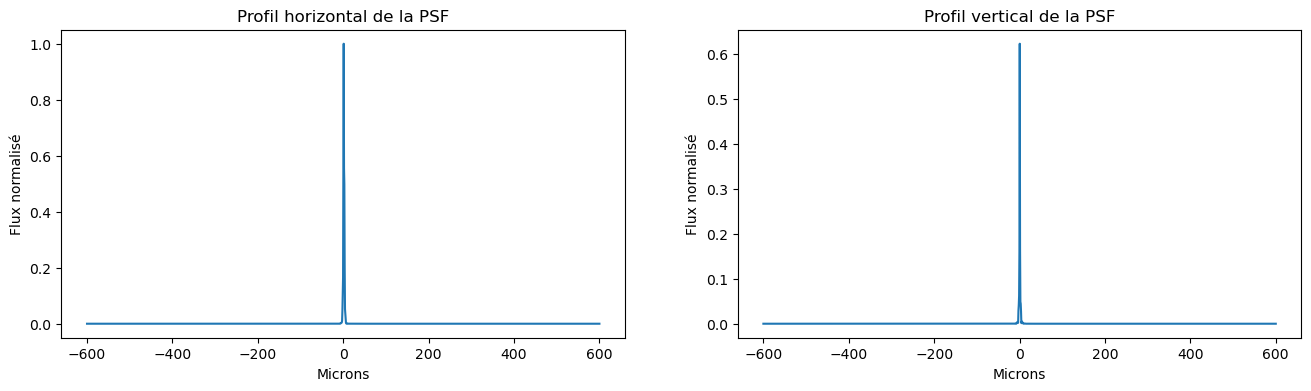

In [11]:
psf = fftpsf.array / fftpsf.array.max()
mid = psf.shape[0] // 2  # indice central
xpsf = np.linspace(-600, 600, len(psf))

fig = plt.figure(figsize=(16, 4))

plt.subplot(1, 2, 1)
plt.plot(xpsf, psf[mid, :])    # coupe horizontale
plt.title("Profil horizontal de la PSF")
plt.xlabel("Microns")
plt.ylabel("Flux normalisé")

plt.subplot(1, 2, 2)
plt.plot(xpsf, psf[:, mid])    # coupe verticale
plt.title("Profil vertical de la PSF")
plt.xlabel("Microns")
plt.ylabel("Flux normalisé")

plt.show()

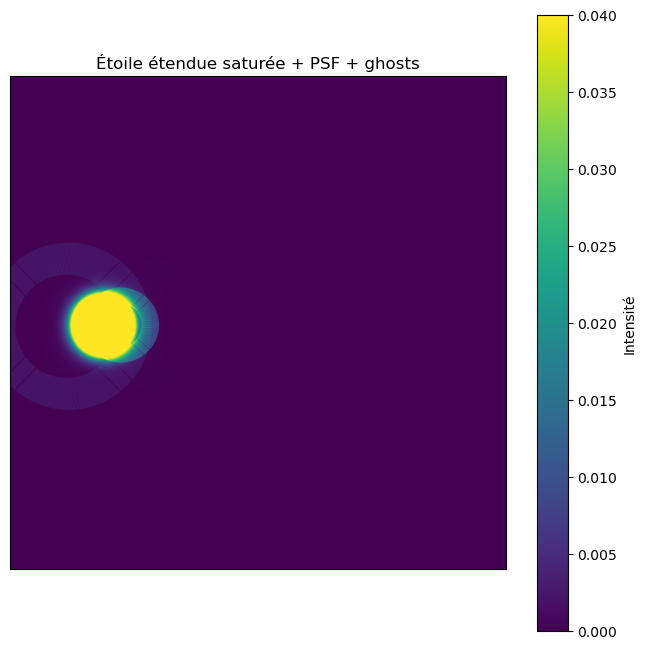

In [12]:
# Taille de l'image
nx, ny = 1586, 1577

# Coordonnées du plan image (en pixels)
y, x = np.indices((ny, nx))
cx, cy = 295, 777  # position de l'étoile

# Paramètres de la gaussienne
sigma = 40         # étendue
amplitude = 1      # flux total arbitraire (peut être n'importe quoi)
saturation_level = 1000  # seuil de saturation (valeurs max sur le capteur)

# Génération d'une source étendue (gaussienne)
source = amplitude * np.exp(-((x - cx)**2 + (y - cy)**2) / (2 * sigma**2))

# Saturation centrale : on clip les valeurs au niveau de saturation
source_sat = np.clip(source, 0, saturation_level)

# Normalisation de la PSF
psf_norm = fftpsf.array / fftpsf.array.sum()

# Convolution (floutage) avec la PSF
image_observee = fftconvolve(source_sat, psf_norm, mode='same')

# Ajout de la carte de ghosts (supposée déjà dans le même référentiel et résolution)
image_observee += ghost_map.T

# Affichage
plt.figure(figsize=(8, 8))
plt.imshow(image_observee, origin='lower', vmax=4e-2)
plt.colorbar(label="Intensité")
plt.title("Étoile étendue saturée + PSF + ghosts")
plt.xticks([])
plt.yticks([])
plt.show()

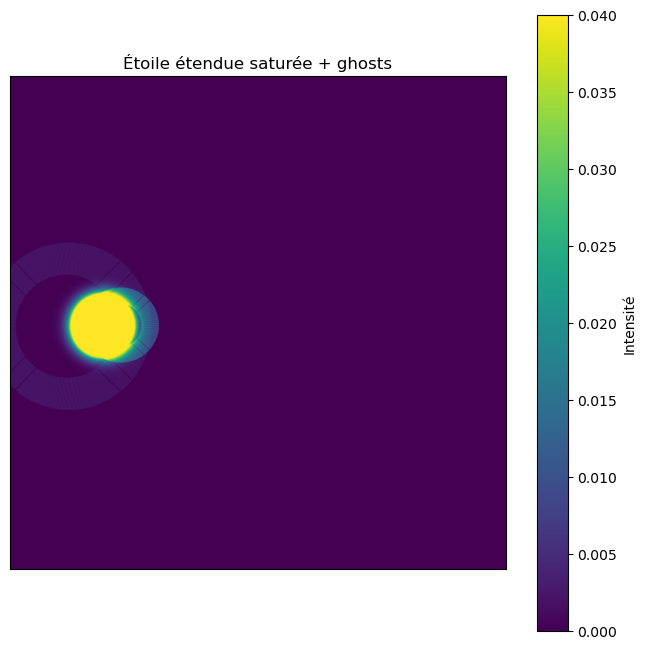

In [13]:
image_observee2 = source_sat + ghost_map.T
plt.figure(figsize=(8, 8))
plt.imshow(image_observee2, origin='lower', vmax=4e-2)
plt.colorbar(label="Intensité")
plt.title("Étoile étendue saturée + ghosts")
plt.xticks([])
plt.yticks([])
plt.show()

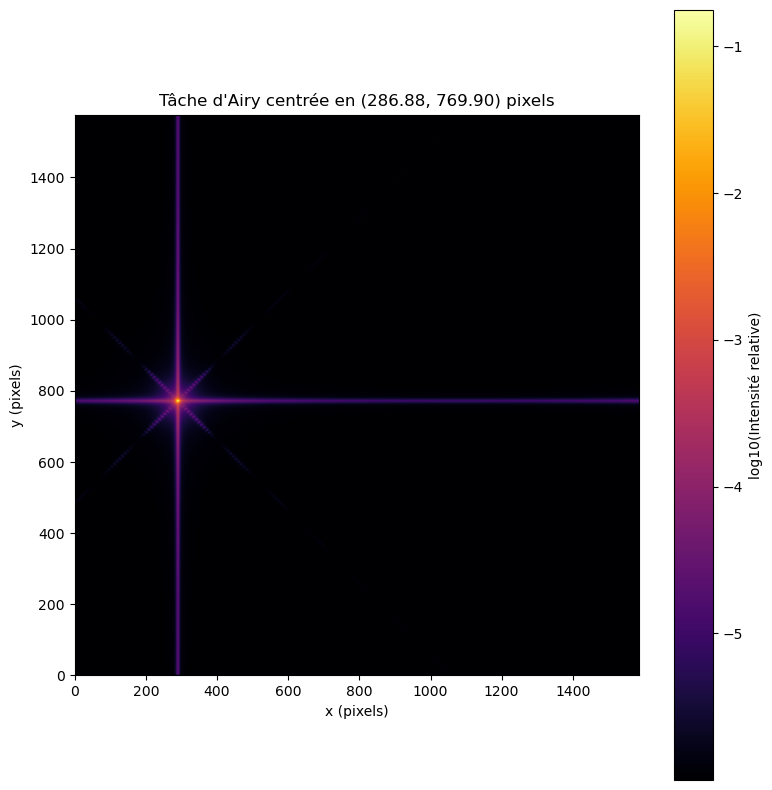

In [14]:
from scipy.special import j1
from scipy.ndimage import rotate

# --- Paramètres physiques (données LSSTCam) ---
binning = 8.0
lambda_ = 666e-9  # m
D = 6.5           # m
f = 0.81          # m

theta = 1.22 * lambda_ / D
rayon_image_m = f * theta


# --- Taille de l'image ---
Ny, Nx = 1577, 1586      # Taille de l'image en pixels
pixel_scale_arcsec = 0.2*binning  # 0.2 arcsec/pixel
pixel_scale_rad = pixel_scale_arcsec * np.pi / (180 * 3600)
pixel_scale_m = f * pixel_scale_rad  # Conversion en m/pixel

# Calcul du champ de vue
FOV_x = Nx * pixel_scale_m
FOV_y = Ny * pixel_scale_m

# --- Coordonnées dans le plan image ---
x = np.linspace(-FOV_x / 2, FOV_x / 2, Nx)
y = np.linspace(-FOV_y / 2, FOV_y / 2, Ny)
X, Y = np.meshgrid(x, y)
R = np.sqrt(X**2 + Y**2)

# --- Motif d’Airy ---
k = 2 * np.pi / wavelength
alpha = k * D * R / (2 * f)
airy = (2 * j1(alpha) / alpha)**2
airy /= airy.max()

# --- Rotation ---
theta = -77.89209882814671  # en degrés (sens trigo)
airy_rotated = rotate(airy, angle=theta, reshape=False, order=3)

# --- Position de l’étoile en pixels ---
x_star = 286.87692047715433
y_star = 769.9001264140228

# --- Décalage sous-pixel via FFT ---
def fourier_shift(image, dx, dy):
    ny, nx = image.shape
    fx = np.fft.fftfreq(nx)
    fy = np.fft.fftfreq(ny)
    FX, FY = np.meshgrid(fx, fy)
    shift_phase = np.exp(-2j * np.pi * (FX * dx + FY * dy))
    f_image = np.fft.fft2(image)
    f_shifted = f_image * shift_phase
    return np.abs(np.fft.ifft2(f_shifted))

# Calcul du shift
shift_x = x_star - Nx / 2.0
shift_y = y_star - Ny / 2.0

# Appliquer le décalage
image = fourier_shift(airy_rotated, shift_x, shift_y)
image_psf = fftconvolve(image, psf_norm, mode='same')

# --- Affichage ---
plt.figure(figsize=(8, 8))
plt.imshow(np.log10(image_psf + 1e-6), cmap='inferno',
           extent=[0, Nx, 0, Ny], origin='lower')
plt.title(f"Tâche d'Airy centrée en ({x_star:.2f}, {y_star:.2f}) pixels")
plt.xlabel("x (pixels)")
plt.ylabel("y (pixels)")
plt.colorbar(label="log10(Intensité relative)")
plt.tight_layout()
plt.show()

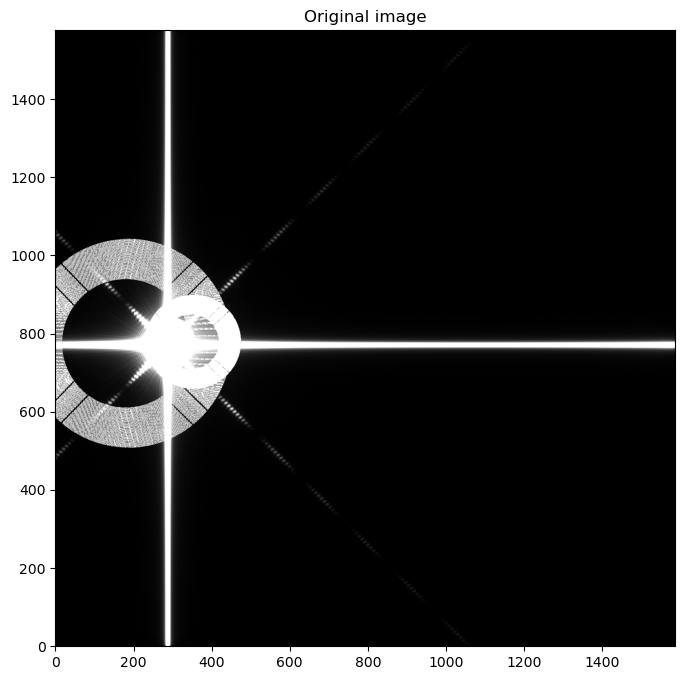

In [15]:
import sys
import os
sys.path.insert(0, os.path.abspath('../src'))
from ghost_buster import display_image as display

display.displayReal(image_psf+ghost_map.T)